In [165]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [166]:
# Load both datasets
loan_data = pd.read_csv('loan_application_simulation.csv')
repayment_data = pd.read_csv('repayment_behavior_simulation.csv')

merged_data = pd.merge(loan_data, repayment_data, 
                       on=['Applicant_ID', 'Loan_Amount_Requested', 'Loan_Term'], 
                       how='left')

In [167]:
# Filter the merged data to get only rows where 'Month' is 12 to use for imputation
december_data = merged_data[merged_data['Month'] == 12]

# Create mappings for columns to be imputed based on December data
approval_status_map = december_data.set_index('Applicant_ID')['Approval_Status'].to_dict()
loan_amount_map = december_data.set_index('Applicant_ID')['Loan_Amount_Requested'].to_dict()
loan_term_map = december_data.set_index('Applicant_ID')['Loan_Term'].to_dict()
purpose_map = december_data.set_index('Applicant_ID')['Purpose'].to_dict()

# Function to safely impute values based on December data for each Applicant_ID
def impute_value_safe(row, col_map, col_name):
    # Use the value from col_map if available; otherwise, use the existing row value
    return col_map.get(row['Applicant_ID'], row.get(col_name, None))

# Impute the values for 'Approval_Status', 'Loan_Amount_Requested', 'Loan_Term', and 'Purpose' for all months
merged_data['Approval_Status'] = merged_data.apply(impute_value_safe, col_map=approval_status_map, col_name='Approval_Status', axis=1)
merged_data['Loan_Amount_Requested'] = merged_data.apply(impute_value_safe, col_map=loan_amount_map, col_name='Loan_Amount_Requested', axis=1)
merged_data['Loan_Term'] = merged_data.apply(impute_value_safe, col_map=loan_term_map, col_name='Loan_Term', axis=1)
merged_data['Purpose'] = merged_data.apply(impute_value_safe, col_map=purpose_map, col_name='Purpose', axis=1)

# Encode 'Approval_Status' as binary: 1 for 'Approved' and 0 for 'Rejected'
merged_data['Approval_Status'] = merged_data['Approval_Status'].map({'Approved': 1, 'Rejected': 0})

# Encode categorical columns
# Identify binary categorical variables
binary_cols = [col for col in merged_data.select_dtypes(include=['object']).columns if merged_data[col].nunique() == 2]

# Map binary columns to 1 and 0
for col in binary_cols:
    unique_values = merged_data[col].unique()
    merged_data[col] = merged_data[col].map({unique_values[0]: 0, unique_values[1]: 1})

# One-hot encode the 'Purpose' column
merged_data = pd.get_dummies(merged_data, columns=['Purpose'], drop_first=True)


Accuracy: 0.55
Precision: 0.45
Recall: 0.58
AUC Score: 0.58


<Figure size 600x600 with 0 Axes>

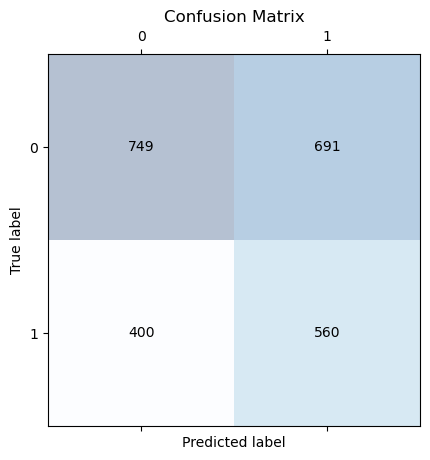

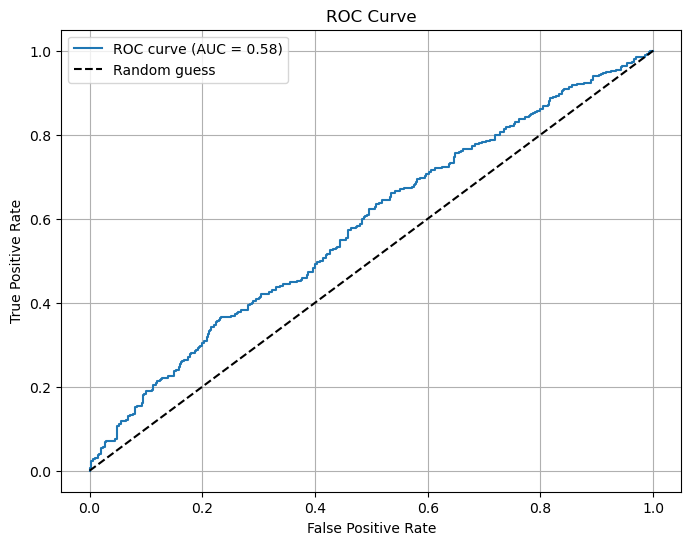

In [168]:
# Step 1: Data Preparation
# Select relevant features based on domain knowledge and the dataset
selected_features = ['Annual_Income', 'House_Status', 'Employment_Status', 'Employment_History_Years', 
                     'Utility_Bill_Payment_Score', 'Number_of_Open_Accounts', 
                     'Credit_History_Years', 'Online_Spending_Behavior_Score'] + \
                    [col for col in merged_data.columns if col.startswith('Purpose_')]

# Target variable
target = 'Approval_Status'

# Drop rows with missing values in the selected columns
filtered_data = merged_data.dropna(subset=selected_features + [target])

# Split the data into features (X) and target (y)
X = filtered_data[selected_features]
y = filtered_data[target]

# Split into training and testing sets (80% training, 20% testing) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Model Training with Feature Scaling and Class Weights
# Create a pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('log_reg', LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', C=1.0))  # Logistic Regression with L2 regularization
])

# Train the model
pipeline.fit(X_train, y_train)

# Step 3: Model Evaluation
# Make predictions
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve and AUC

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_prob)

# Display evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUC Score: {auc_score:.2f}")

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()